### Bigplot Example

David Fleming, August 2016

---

In this notebook, I'll run through the basic functionality of bigplanet's plotting subpackage, bigplot.

In [1]:
#Imports
%matplotlib inline

from __future__ import print_function, division, absolute_import

#Imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['font.size'] = 22.0

## for Palatino and other serif fonts use:
mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
mpl.rc('text', usetex=True)

# 0) Import bigplanet

---

bigplanet can be imported and used just like any other python module.

In [2]:
from bigplanet import bigplot as bp
from bigplanet import data_extraction as de

# 1) Load in Data

---

Let's say we ran a simulation where we varied several body parameters in some grid over parameters such as binary semimajor axis, eccentricity and the same for a circumbinary planet (CBP).  The suite of simulations, set up using ``vspace``, produced a lot of directories, one for each simulation, so in order to work with the data products, we need to traverse through each directory, extract the results, and transform them into a meaningful data structure.  

Currently, ``bigplanet`` supports extracting data into a hdf5 dataset.  The hdf5 format is a versitile compressed file format that allows for quick access of data that cannot fit into memory.  The hdf5 format stores array-like data in a POSIX-like filetree system that supports random-access by decompressing the given data in real-time that is only a factor of a few slower than if one was accessing the data from memory.  Since VPLANET simulations have a simulation-body-variable hierarchy, it makes sense to use a hierarchical format.  

For more info on all things hdf5, check out these links:

hdf5 with python: http://docs.h5py.org/en/latest/quick.html

hdf5 general: https://en.wikipedia.org/wiki/Hierarchical_Data_Format (the h, d, and f from hdf5!)

hdf5 group: https://www.hdfgroup.org/HDF5/

** Tell bigplanet where the data is **

---

Here, we'll load the data into the variable data.  When using the hdf5 format, data is actually an object that stores metadata about the hdf5 dataset for ease of manipulation.  For this, we must make known the source directory, src and the path to the hdf5 dataset, dataset.

In [3]:
# Path to the root directory where all the simulation subdirectories live
src = "/Users/dflemin3/Desktop/GM_run/"

# Define name for the dataset (hdf5 approach)
dataset = src + "simulation.hdf5"

# Define a data format
fmt = "hdf5"

** Load in the data!**

---

Here we actually get a data object to manipulate and work with.  This bit of code discriminates between the two formats and prints out useful information.  I should make this into a function.  The core of this "function" occurs in the following line
>    data = de.extract_data_hdf5(src=src, dataset=dataset,**kwargs)

We pass the extract_data_hdf5 function the source directory src and the name of the dataset, dataset.  If the dataset does not exist, i.e. all the data directories in source have not been traversed and parsed, then the function will traverse the simulation directories and store the data into dataset.  On my slow laptop, this takes ~1.5 minutes for ~1000 simulations.  If dataset does exist, it's quickly loaded into data.  See the data_example for a more in-depth description.

In [4]:
data = de.extract_data_hdf5(src=src, dataset=dataset, order="grid",compression="gzip")
print(data)

Hdf5 dataset already exists.  Reading from: /Users/dflemin3/Desktop/GM_run/simulation.hdf5.
Using size, order stored in dataset.
Name: /Users/dflemin3/Desktop/GM_run/simulation.hdf5. Size: 625. Order: grid


** Plotting with dataframes **

Bigplot relies heavily on dataframes for visualization.  Often times, we want to plot how simulation results vary as a function of the initial conditions.  With bigplanet, it is easy to make dataframes that store the initial conditions, be it gridded or randomly sampled initial conditions, and to run complex analysis routines that process a simulation result and stores that as a dependent variable of simulation results.  For example, we may wish to plot a planet's maximum eccentricity as

With the dataset object created using the aggregate_data function, we can either make a new dataframe or load in a cached one.  See the data_example for more information on the dataframe.  Here, we'll load one in.

In [5]:
df = de.aggregate_data(cache=src+"trivial_cache.pkl")

Reading data from cache: /Users/dflemin3/Desktop/GM_run/trivial_cache.pkl


** What does df look like?**

In [6]:
# Dataframe with new column produced by user-defined function!
df.head(5)

,cbp_Eccentricity,cbp_InitEcc,cbp_SemimajorAxis,secondary_Eccentricity,secondary_SemimajorAxis
0,0.038669,0.038669,0.498178,0.01,0.05
1,0.038107,0.038107,0.672144,0.01,0.05
2,0.037851,0.037851,0.846260,0.01,0.05
3,0.037713,0.037713,1.020163,0.01,0.05
4,0.037632,0.037632,1.194305,0.01,0.05


# 2) Plotting

** Simple plot: Max eccentricity vs initial eccentricity over all simulations **

In [22]:
# Get the data.  Note it's not as quick as in-memory for loops since we're
# dynamically decompressing the data
ecc = np.zeros(data.size)
max_ecc = np.zeros(data.size)

for i in range(0,data.size):
    tmp = data.get(i,"cbp","Eccentricity")
    ecc[i] = tmp[0]
    max_ecc[i] = np.nanmax(tmp)

(0, 0.8)

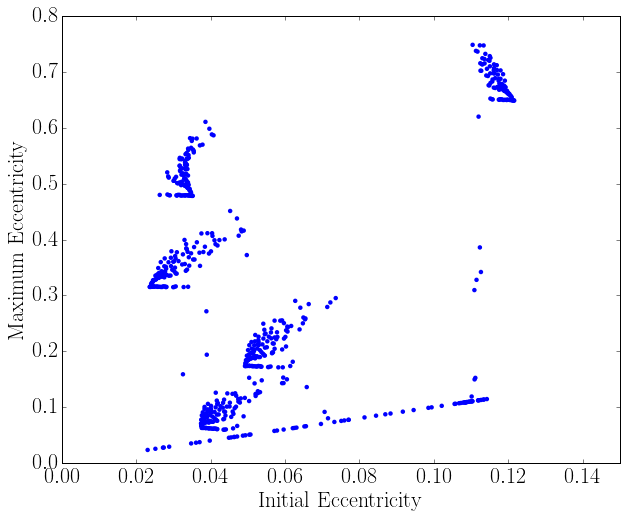

In [9]:
# Plot!
fig, ax = plt.subplots()

ax.scatter(ecc,max_ecc,edgecolor="none")

# Format plot
ax.set_xlabel("Initial Eccentricity")
ax.set_ylabel("Maximum Eccentricity")
ax.set_xlim(0,0.15)
ax.set_ylim(0,0.8)

### More complex plots that leverage the dimensionality of the data 

---

Now let's use the dataframe df we created in the section about to generate a summary plot for our simulation suite.  With any large, high-dimensional simulation suite, we'll vary over more parameters than we can neatly plot in a single figure.  Instead of making a confusogram (right now), we'll plot some variable as a function of 2 initial coniditions and marginalize over all other dimensions.  For example, if we want to visualize the trivial result of how initial CBP eccentricity varies as a function of binary semimajor axis and eccentricity, we'll need to average over other dimensions.  Naturally when marginalizing over other dimensions, the user should ensure that he/she are not losing information in the process.

** Shape **

Before I get into the plotting functions, I want to introduce the concept of the simulation suite's shape.  In this small test suite, I used vspace to vary binary eccentricity, semimajor axis and the same for the planet in 5 steps.  See the below vspace input file.

Shape is important for gridded data as it informs the code how exactly to marginalize over the higher dimensions.  This is not the same as projecting some randomly distributed data down to 2D.

In [7]:
! cat /Users/dflemin3/Desktop/GM_run/input

srcfolder  /usr/lusers/dflemin3/bin/vplanet/examples/binary_hyak
destfolder /gscratch/stf/dflemin3/vplanet_sims/GM_test
trialname  GM_sim

file   primary.in

file   secondary.in
dEcc  [0.01,0.3,n5] be
dSemi [0.05,0.2,n5] ba

file cbp.in
dFreeEcc [0.05,0.3,n5] cfe
dSemi [0.5,1.2,n5] ca

file   vpl.in


From inspection, we can see that the shape of this dataset is 5 x 5 x 5 x 5.  When using functions that marginalize over other dimensions, the shape must be specified as an interable so the function knows how to compress the data.

** Dims **

Similar to shape, the dimensions over which we must marginalize must be known to the function.  This allows the function to know exactly what it must marginalize over.  Dims defaults to -1 (marginalize over the last dimension) but in general is an iterable.

** Can we plot yet?**

Almost.  To use the function, we need to specify a few things.  First, we need x, y and the color variable z.  These are accessed from the dataframe df.  Next, we specify the shape in the manner described above.  Then, we create a figure and axis, if we haven't already, for the plot to live on.  Finally, we have the option of passing the axis labels.  Then plot!

** Imshow with Gaussian Interpolation **

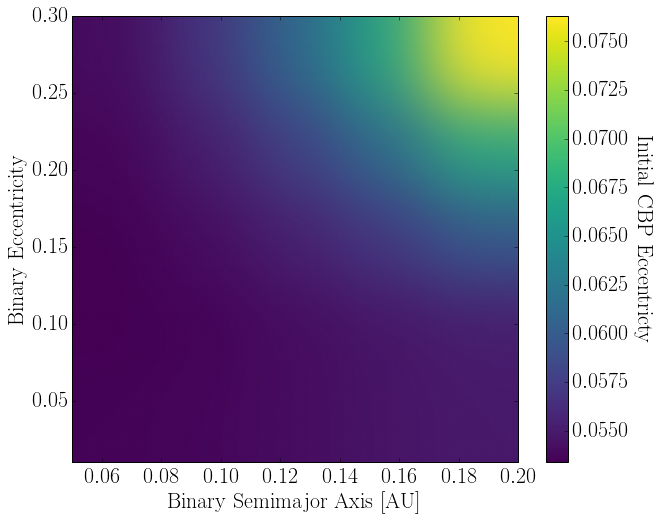

In [10]:
# Init axes labels, data to plot
labels = ["Binary Semimajor Axis [AU]", "Binary Eccentricity", "Initial CBP Eccentricty"]
x = df["secondary_SemimajorAxis"]
y = df["secondary_Eccentricity"]
z = df["cbp_InitEcc"]

# Shape of the data
shape = (5, 5, 5, 5)

# Dimensions to compress over
dims = (-2, -1)

fig, ax = plt.subplots()

bp.plot_red_dim(x, y, z, shape, fig, ax, dims=dims, labels=labels)

** Contour plot with user-defined number of contours (levels) **

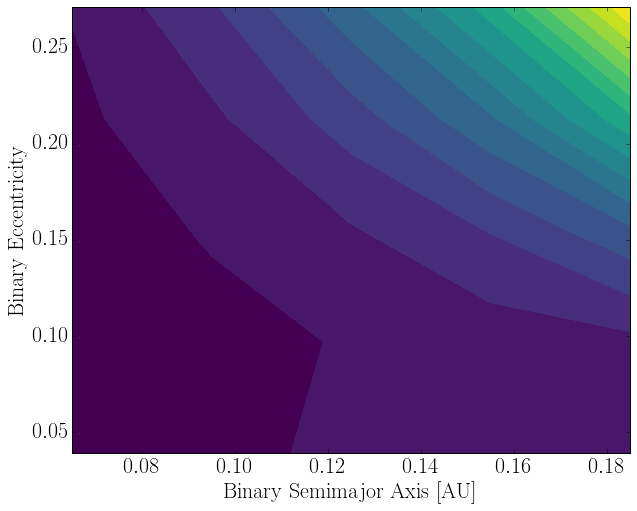

In [11]:
# Init axes labels, data to plot
labels = ["Binary Semimajor Axis [AU]", "Binary Eccentricity", "Initial CBP Eccentricty"]
x = df["secondary_SemimajorAxis"]
y = df["secondary_Eccentricity"]
z = df["cbp_Eccentricity"]

# Shape of the data
shape = (5, 5, 5, 5)

# Dimensions to compress over
dims = (-2, -1)

# Number of levels for a contour plot
levels = 15

fig, ax = plt.subplots()

bp.plot_red_dim_contour(x, y, z, shape, fig, ax, dims=dims, labels=labels, levels=levels)

** We're astronomers and want to plot everything vs everything, damnit! **

Well you're in luck!  Bigplot has a routine, red_dim_grid, that allows you to plot all marginalized plots for each initial condition vs each other colored by a user-specified dependent variable.  Not only does this function produce the marginalized plots in the below lower-left triangle, but in the upper right triangle it plots the same variable vs variable but colored by some measure of the variance of the dependent variable.  The upper right triangle essentially probes how much information is preserved/lost when one marginalized over the other dimensions to produce the plots in the lower left triangle.

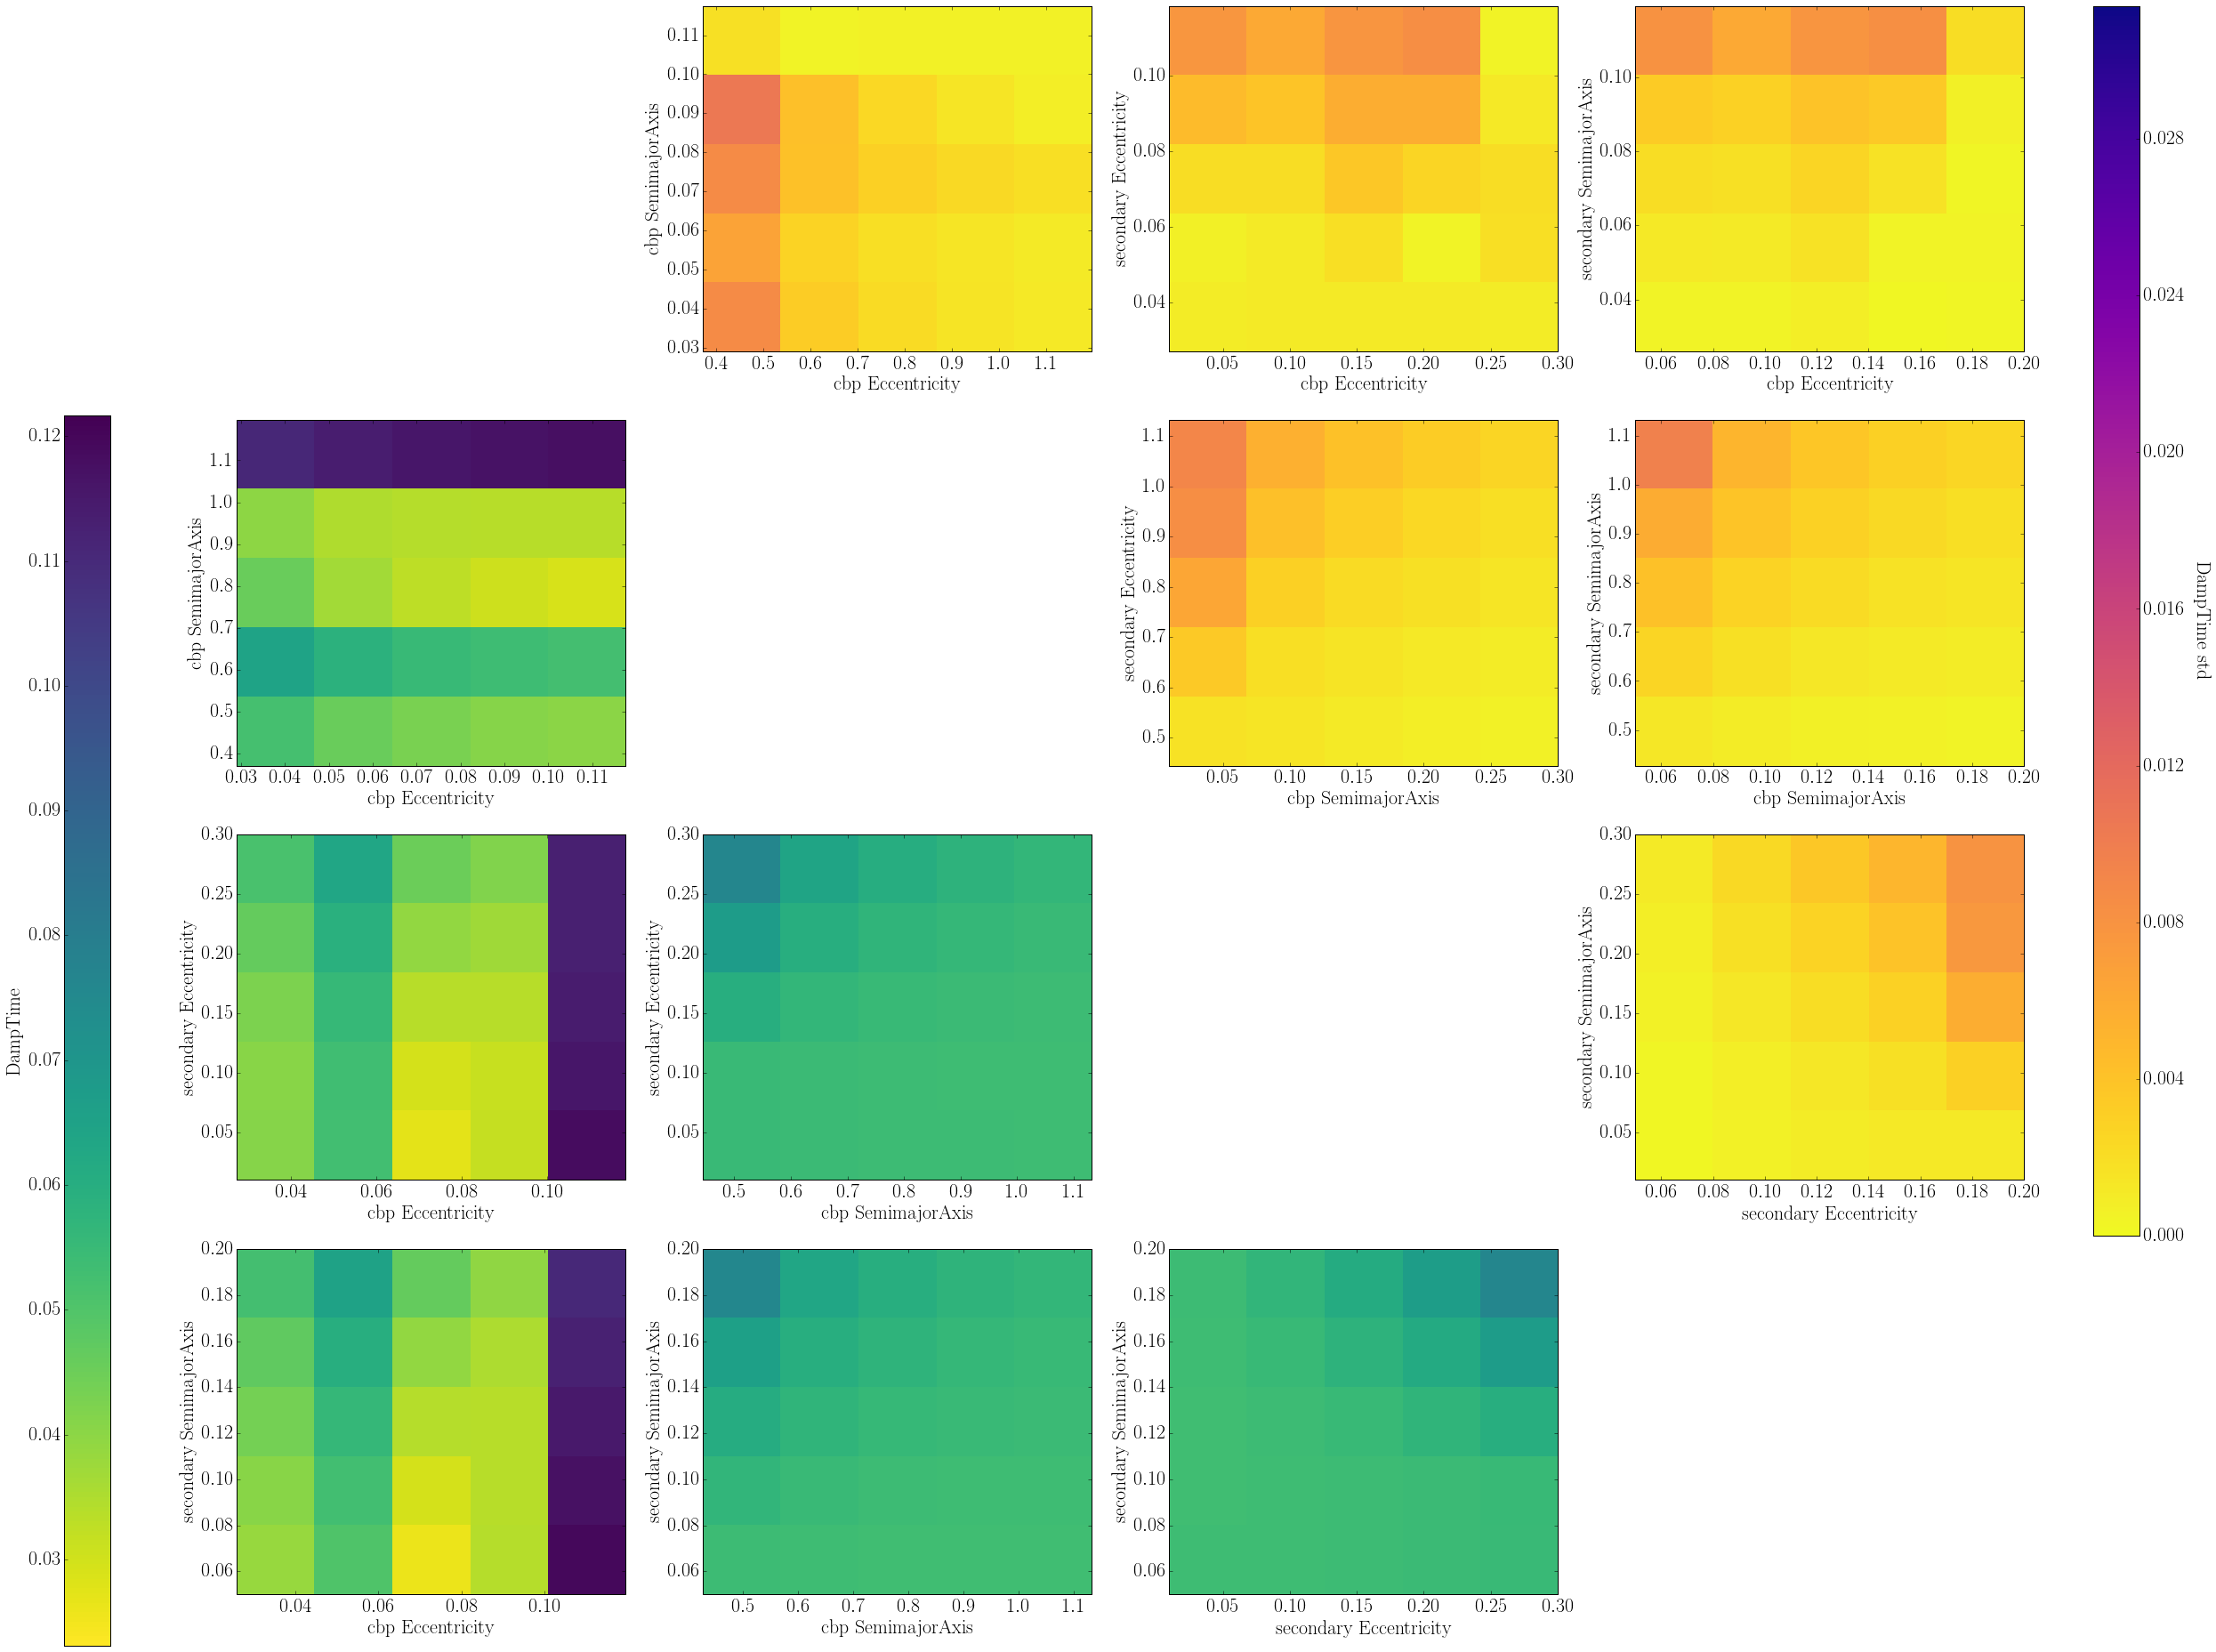

In [12]:
# Define the shape
shape = {"secondary" : {"Eccentricity" : 5, "SemimajorAxis" : 5}, "cbp" : {"Eccentricity" : 5,
                                                                          "SemimajorAxis" : 5}}

dims = {"secondary" : {"Eccentricity" : 0, "SemimajorAxis" : 1}, "cbp": {"Eccentricity" : 2,
                                                                        "SemimajorAxis" : 3}}

fig, axes = bp.red_dim_grid(df, shape, dims, color_by="cbp_InitEcc", interp="nearest",
                        lcmap="viridis_r",rcmap="plasma_r",save=False, right_color_func = np.std,
                           nan_value=8.0e9)

** More everything vs everything! **

---

This next function, multiscatter, allows you to plot one dependent variable versus all other variables where each point can optionally be colored and sized by two other variables.  All the color and size scaling are done internally for easy usage.

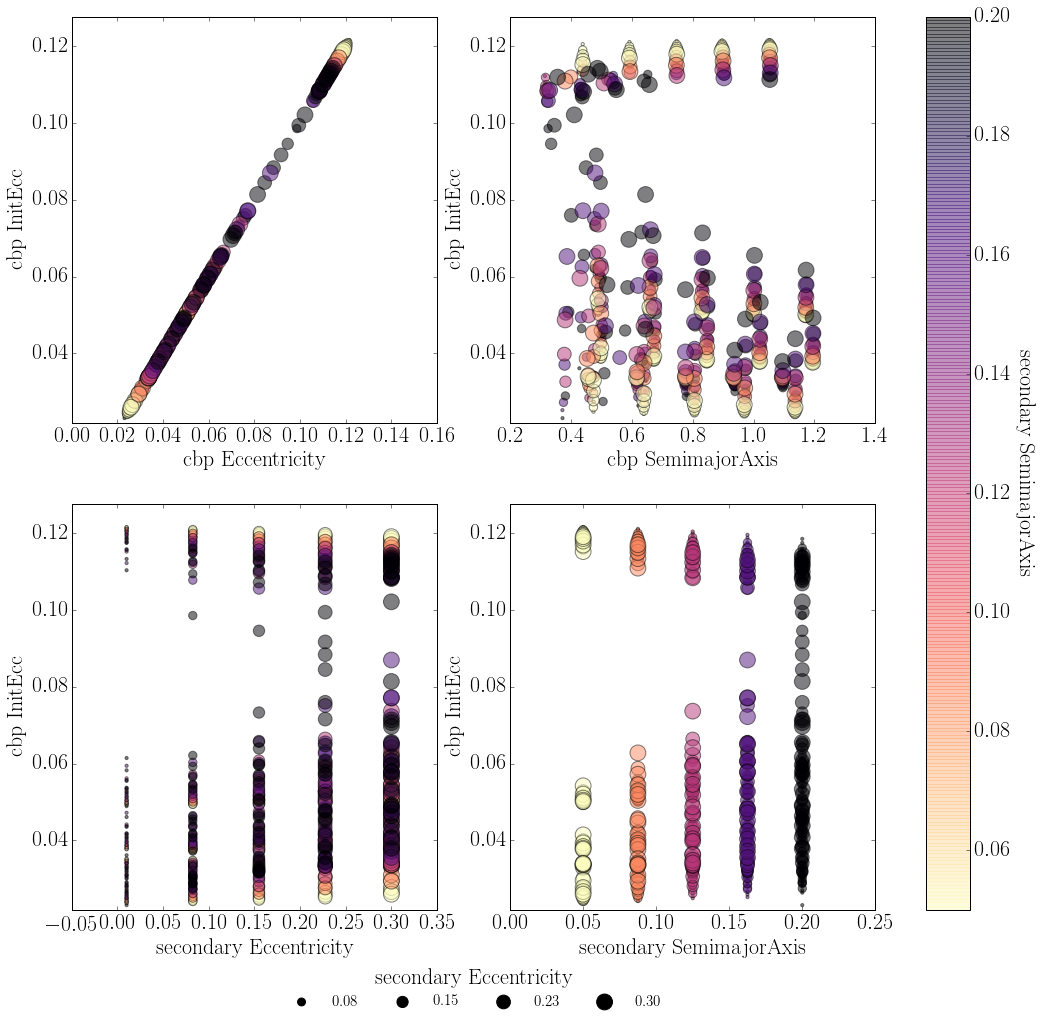

In [14]:
fig, axes = bp.multiscatter(df,z_var="cbp_InitEcc",size_var="secondary_Eccentricity",
                            color_var="secondary_SemimajorAxis")